#
루브릭 기준
========

|평가문항|상세기준|
|------|---|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어 있음|
|2. ARIMA 모델 모수 선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|


#
모듈 불러오기
----------

In [1490]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
from os.path import join
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

#
STEP 1 : 시계열 데이터 준비
=======================

* ### 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* ### 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* ### 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

#
애플, 구글, 아마존 데이터 불러오기
---------------------------

In [1491]:
dataset_filepath = os.getenv('HOME') + '/Aiffel/Exploration/data'

aapl_data_path = join(dataset_filepath, 'AAPL.csv')
goog_data_path = join(dataset_filepath, 'GOOG.csv')
amzn_data_path = join(dataset_filepath, 'AMZN.csv')

aapl_df = pd.read_csv(aapl_data_path, index_col='Date', parse_dates=True)
goog_df = pd.read_csv(goog_data_path, index_col='Date', parse_dates=True)
amzn_df = pd.read_csv(amzn_data_path, index_col='Date', parse_dates=True)

#컬럼 확인하기
print(aapl_df.columns)
print(goog_df.columns)
print(amzn_df.columns)

#날짜별 데이터 확인
print(aapl_df.head())
print(goog_df.head())
print(amzn_df.head())


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-12-15  175.110001  179.500000  172.309998  179.300003  178.265396   
2021-12-16  179.279999  181.139999  170.750000  172.259995  171.266006   
2021-12-17  169.929993  173.470001  169.690002  171.139999  170.152466   
2021-12-20  168.279999  170.580002  167.460007  169.750000  168.770493   
2021-12-21  171.559998  173.199997  169.119995  172.990005  171.991806   

               Volume  
Date                   
2021-12-15  131063300  
2021-12-16  150185800  
2021-12-17  195432700  
2021-12-20  107499100  
2021-12-21   91185900  
                  Open        High         Low       Close   Adj Close  \
Da

#
## 종가(close)만 분리하기

In [1492]:
aapl_ts = aapl_df['Close']
goog_ts = goog_df['Close']
amzn_ts = amzn_df['Close']

print(aapl_ts.head())
print(goog_ts.head())
print(amzn_ts.head())

Date
2021-12-15    179.300003
2021-12-16    172.259995
2021-12-17    171.139999
2021-12-20    169.750000
2021-12-21    172.990005
Name: Close, dtype: float64
Date
2021-12-15    147.368500
2021-12-16    144.838501
2021-12-17    142.802994
2021-12-20    142.401505
2021-12-21    144.220505
Name: Close, dtype: float64
Date
2021-12-15    173.315002
2021-12-16    168.871002
2021-12-17    170.017502
2021-12-20    167.078995
2021-12-21    170.417007
Name: Close, dtype: float64


STEP 2 : 각종 전처리 수행
=====================

* ### 결측치 처리
* ### 로그 변환

#
결측치 처리
---------

In [1493]:
print(aapl_ts[aapl_ts.isna()])
print(goog_ts[goog_ts.isna()])
print(amzn_ts[amzn_ts.isna()])

Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)


#
## 로그 변환

In [1494]:
aapl_ts_log = np.log(aapl_ts)
goog_ts_log = np.log(goog_ts)
amzn_ts_log = np.log(amzn_ts)

print(aapl_ts_log)
print(goog_ts_log)
print(amzn_ts_log)

Date
2021-12-15    5.189060
2021-12-16    5.149005
2021-12-17    5.142482
2021-12-20    5.134327
2021-12-21    5.153234
                ...   
2022-12-08    4.960394
2022-12-09    4.956953
2022-12-12    4.973210
2022-12-13    4.979970
2022-12-14    4.964312
Name: Close, Length: 252, dtype: float64
Date
2021-12-15    4.992936
2021-12-16    4.975619
2021-12-17    4.961466
2021-12-20    4.958651
2021-12-21    4.971343
                ...   
2022-12-08    4.542763
2022-12-09    4.533352
2022-12-12    4.538603
2022-12-13    4.562784
2022-12-14    4.557135
Name: Close, Length: 252, dtype: float64
Date
2021-12-15    5.155111
2021-12-16    5.129135
2021-12-17    5.135901
2021-12-20    5.118467
2021-12-21    5.138248
                ...   
2022-12-08    4.503691
2022-12-09    4.489647
2022-12-12    4.505902
2022-12-13    4.527101
2022-12-14    4.517213
Name: Close, Length: 252, dtype: float64


#
STEP 3 : 시계열 안정성 분석
=======================

* ### 정성적 그래프 분석
* ### 정량적 Augmented Dicky-Fuller Test
* ### 시계열 분해(Time Series Decomposition)
* ### Residual 안정성 확인

#
## 정성적 그래프 분석

#
### 구간 통계치 시각화 함수

In [1495]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() 
    rolstd = timeseries.rolling(window=window).std()   

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


 [AAPL]


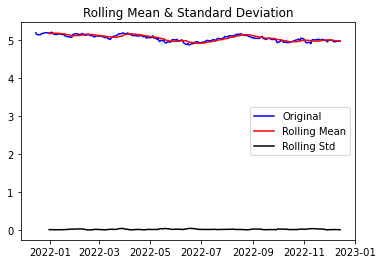


 [GOOG]


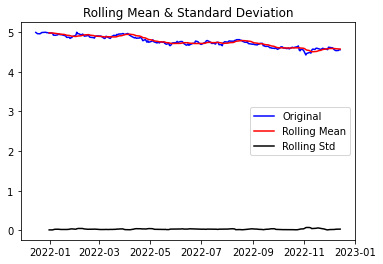


 [AMZN]


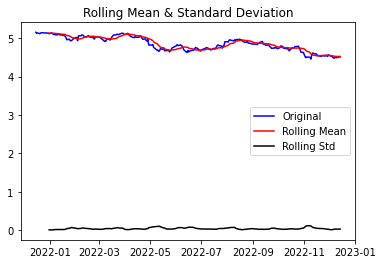

In [1496]:
print('\n [AAPL]')
plot_rolling_statistics(aapl_ts_log, window=12)

print('\n [GOOG]')
plot_rolling_statistics(goog_ts_log, window=12)

print('\n [AMZN]')
plot_rolling_statistics(amzn_ts_log, window=12)

#
## 정량적 Augmented Dicky-Fuller Test

#
### ADF Test 함수

In [1497]:
def augmented_dickey_fuller_test(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [1498]:
print('\n [AAPL]')
augmented_dickey_fuller_test(aapl_ts_log)


 [AAPL]
Results of Dickey-Fuller Test:
Test Statistic                  -2.356680
p-value                          0.154338
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [1499]:
print('\n [GOOG]')
augmented_dickey_fuller_test(goog_ts_log)



 [GOOG]
Results of Dickey-Fuller Test:
Test Statistic                  -1.516005
p-value                          0.525580
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [1500]:
print('\n [AMZN]')
augmented_dickey_fuller_test(amzn_ts_log)


 [AMZN]
Results of Dickey-Fuller Test:
Test Statistic                  -1.232433
p-value                          0.659491
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


#
## 시계열 분해(Time Series Decomposition)


 [AAPL]


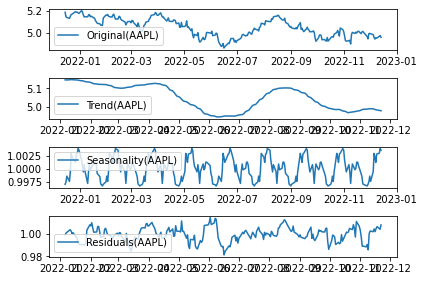

In [1501]:

print('\n [AAPL]')
decomposition = seasonal_decompose(aapl_ts_log, model='multiplicative', period = 30) 

aapl_trend = decomposition.trend
aapl_seasonal = decomposition.seasonal
aapl_residual = decomposition.resid

plt.subplot(411)
plt.plot(aapl_ts_log, label='Original(AAPL)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(aapl_trend, label='Trend(AAPL)')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(aapl_seasonal,label='Seasonality(AAPL)')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(aapl_residual, label='Residuals(AAPL)')
plt.legend(loc='best')
plt.tight_layout()


 [GOOG]


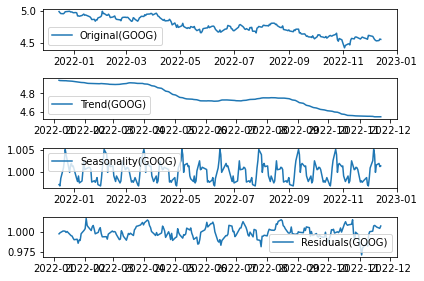

In [1502]:
print('\n [GOOG]')
decomposition = seasonal_decompose(goog_ts_log, model='multiplicative', period = 30) 

goog_trend = decomposition.trend
goog_seasonal = decomposition.seasonal
goog_residual = decomposition.resid

plt.subplot(411)
plt.plot(goog_ts_log, label='Original(GOOG)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(goog_trend, label='Trend(GOOG)')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(goog_seasonal,label='Seasonality(GOOG)')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(goog_residual, label='Residuals(GOOG)')
plt.legend(loc='best')
plt.tight_layout()


 [AMZN]


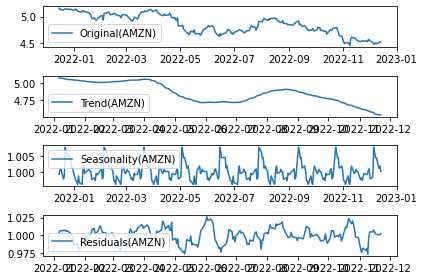

In [1503]:
print('\n [AMZN]')
decomposition = seasonal_decompose(amzn_ts_log, model='multiplicative', period = 30) 

amzn_trend = decomposition.trend
amzn_seasonal = decomposition.seasonal
amzn_residual = decomposition.resid

plt.subplot(411)
plt.plot(amzn_ts_log, label='Original(AMZN)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(amzn_trend, label='Trend(AMZN)')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(amzn_seasonal,label='Seasonality(AMZN)')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(amzn_residual, label='Residuals(AMZN)')
plt.legend(loc='best')
plt.tight_layout()

#
## Residual 안정성 확인

In [1504]:
print('\n [AAPL]')
aapl_residual.dropna(inplace=True)
augmented_dickey_fuller_test(aapl_residual)



 [AAPL]
Results of Dickey-Fuller Test:
Test Statistic                  -5.561785
p-value                          0.000002
#Lags Used                      11.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


In [1505]:
print('\n [GOOG]')
goog_residual.dropna(inplace=True)
augmented_dickey_fuller_test(goog_residual)


 [GOOG]
Results of Dickey-Fuller Test:
Test Statistic                  -5.213448
p-value                          0.000008
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


In [1506]:
print('\n [AMZN]')
amzn_residual.dropna(inplace=True)
augmented_dickey_fuller_test(amzn_residual)


 [AMZN]
Results of Dickey-Fuller Test:
Test Statistic                  -5.299394
p-value                          0.000005
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


#
# STEP 4 : 학습, 테스트 데이터셋 생성


* ### 학습, 테스트 데이터셋 분리



 [AAPL]


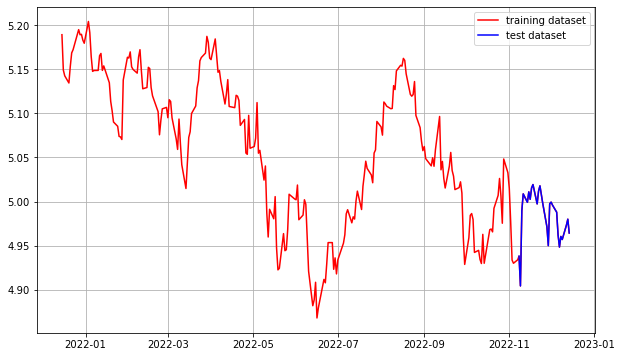

In [1507]:
print('\n [AAPL]')

aapl_train_data, aapl_test_data = aapl_ts_log[:int(len(aapl_ts_log)*0.9)], aapl_ts_log[int(len(aapl_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(aapl_ts_log, c='r', label='training dataset') 
plt.plot(aapl_test_data, c='b', label='test dataset')
plt.legend()


 [GOOG]


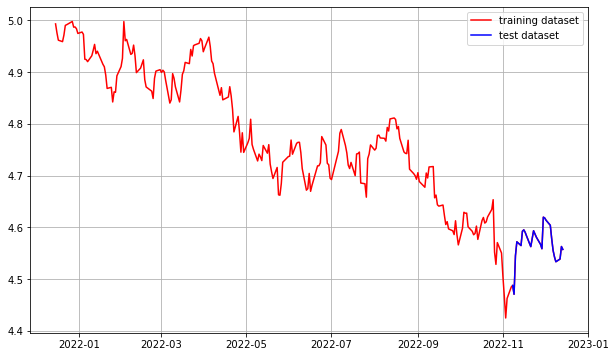

In [1508]:
print('\n [GOOG]')
goog_train_data, goog_test_data = goog_ts_log[:int(len(goog_ts_log)*0.9)], goog_ts_log[int(len(goog_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(goog_ts_log, c='r', label='training dataset') 
plt.plot(goog_test_data, c='b', label='test dataset')
plt.legend()


 [AMZN]


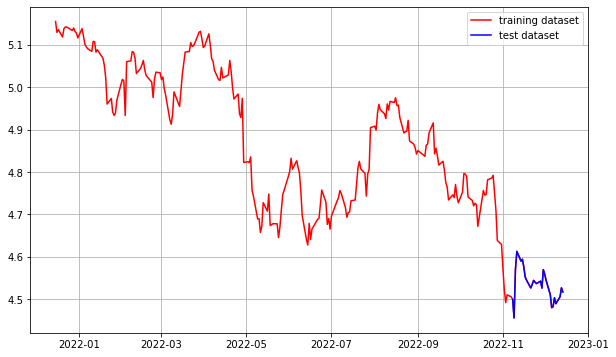

In [1509]:
print('\n [AMZN]')
amzn_train_data, amzn_test_data = amzn_ts_log[:int(len(amzn_ts_log)*0.9)], amzn_ts_log[int(len(amzn_ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(amzn_ts_log, c='r', label='training dataset') 
plt.plot(amzn_test_data, c='b', label='test dataset')
plt.legend()

#
# STEP 5 : 적정 ARIMA 모수 찾기


* ### ACF, PACF 그려보기 -> p,q 구하기
* ### 차분 안정성 확인 -> d 구하기

#
## ACF, PACF 그리기


 [AAPL]


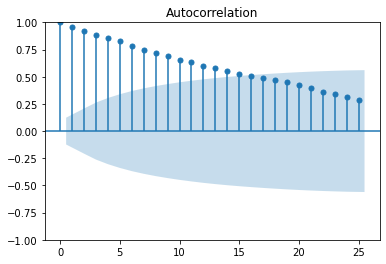

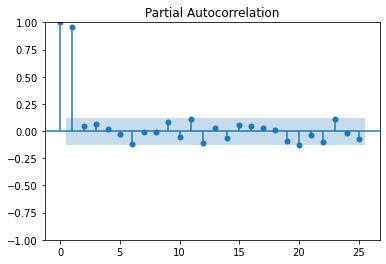

In [1510]:
print('\n [AAPL]')
plot_acf(aapl_ts_log)   
plot_pacf(aapl_ts_log) 
plt.show()


 [GOOG]


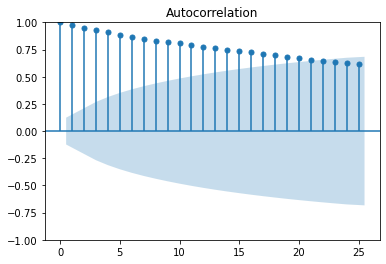

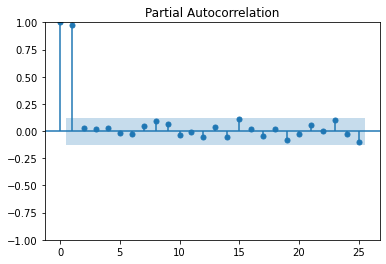

In [1511]:
print('\n [GOOG]')
plot_acf(goog_ts_log)   
plot_pacf(goog_ts_log) 
plt.show()


 [AMZN]


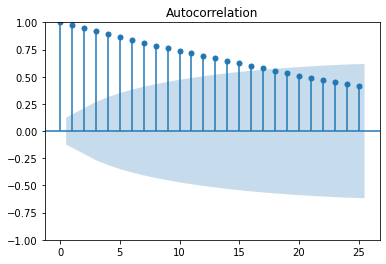

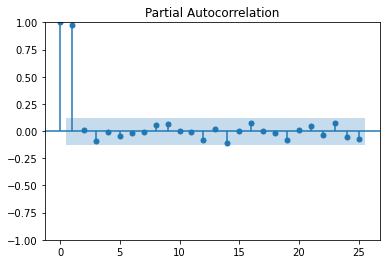

In [1512]:
print('\n [AMZN]')
plot_acf(amzn_ts_log)   
plot_pacf(amzn_ts_log) 
plt.show()


 [AAPL 1st]
Results of Dickey-Fuller Test:
Test Statistic                -1.237105e+01
p-value                        5.280539e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


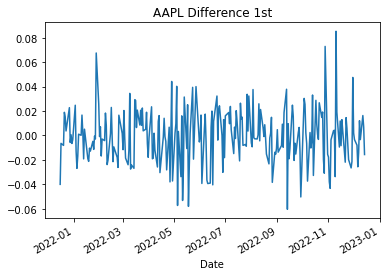

In [1513]:
aapl_diff_1 = aapl_ts_log.diff(periods=1).iloc[1:]
aapl_diff_1.plot(title='AAPL Difference 1st')

print('\n [AAPL 1st]')
augmented_dickey_fuller_test(aapl_diff_1)


 [AAPL 2nd]
Results of Dickey-Fuller Test:
Test Statistic                -8.080154e+00
p-value                        1.468803e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


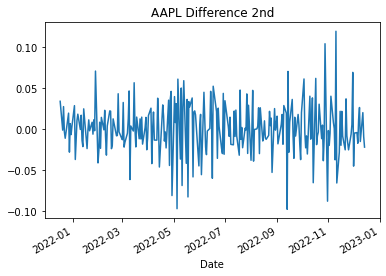

In [1514]:
aapl_diff_2 = aapl_diff_1.diff(periods=1).iloc[1:]
aapl_diff_2.plot(title='AAPL Difference 2nd')

print('\n [AAPL 2nd]')
augmented_dickey_fuller_test(aapl_diff_2)


 [AAPL]


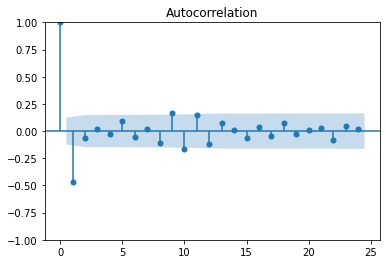

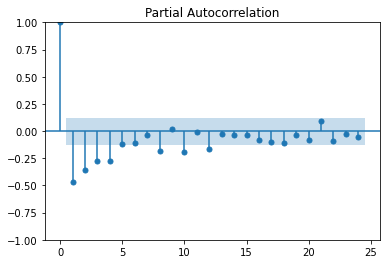

In [1515]:
print('\n [AAPL]')
plot_acf(aapl_diff_2)   
plot_pacf(aapl_diff_2) 
plt.show()


 [GOOG 1st]
Results of Dickey-Fuller Test:
Test Statistic                -1.623628e+01
p-value                        3.766982e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


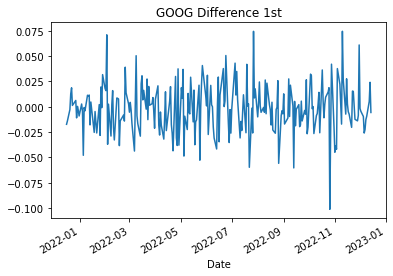

In [1516]:
goog_diff_1 = goog_ts_log.diff(periods=1).iloc[1:]
goog_diff_1.plot(title='GOOG Difference 1st')

print('\n [GOOG 1st]')
augmented_dickey_fuller_test(goog_diff_1)


 [GOOG 2nd]
Results of Dickey-Fuller Test:
Test Statistic                -8.499117e+00
p-value                        1.252238e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


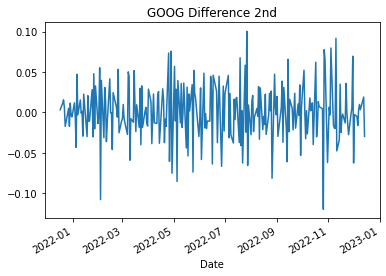

In [1517]:
goog_diff_2 = goog_diff_1.diff(periods=1).iloc[1:]
goog_diff_2.plot(title='GOOG Difference 2nd')

print('\n [GOOG 2nd]')
augmented_dickey_fuller_test(goog_diff_2)


 [GOOG]


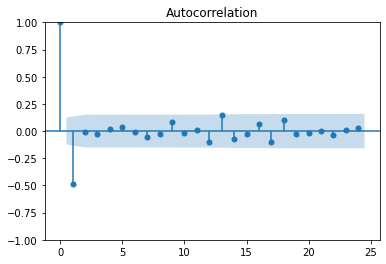

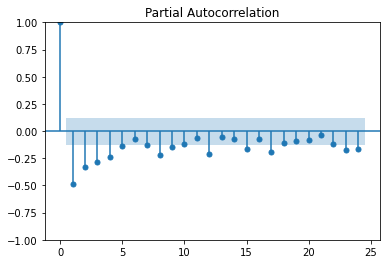

In [1518]:
print('\n [GOOG]')
plot_acf(goog_diff_2)   
plot_pacf(goog_diff_2) 
plt.show()


 [AMZN 1st]
Results of Dickey-Fuller Test:
Test Statistic                -1.568697e+01
p-value                        1.449429e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


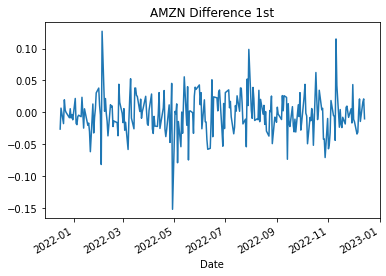

In [1519]:
amzn_diff_1 = amzn_ts_log.diff(periods=1).iloc[1:]
amzn_diff_1.plot(title='AMZN Difference 1st')

print('\n [AMZN 1st]')
augmented_dickey_fuller_test(amzn_diff_1)


 [AMZN 2nd]
Results of Dickey-Fuller Test:
Test Statistic                -8.561488e+00
p-value                        8.671098e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


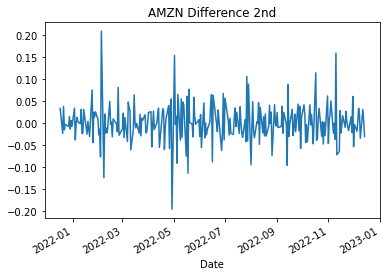

In [1520]:
amzn_diff_2 = amzn_diff_1.diff(periods=1).iloc[1:]
amzn_diff_2.plot(title='AMZN Difference 2nd')

print('\n [AMZN 2nd]')
augmented_dickey_fuller_test(amzn_diff_2)


 [AMZN]


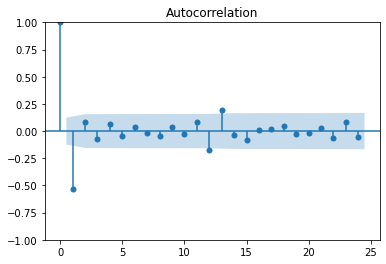

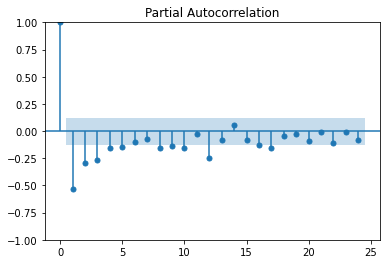

In [1521]:
print('\n [AMZN]')
plot_acf(amzn_diff_2)   
plot_pacf(amzn_diff_2) 
plt.show()

#
# STEP 6 : ARIMA 모델 훈련과 테스트

* ### ARIMA 모델 빌드와 훈련
* ### 모델 테스트 및 플로팅
* ### 최종 예측 모델 정확도 측정(MAPE)

#
## ARIMA 모델 빌드와 훈련

In [1522]:
aapl_model = ARIMA(aapl_train_data, order=(2, 0, 1))  
aapl_fitted_m = aapl_model.fit() 

print('\n [AAPL]')
print(aapl_fitted_m.summary())


 [AAPL]
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 546.225
Date:                Fri, 16 Dec 2022   AIC                          -1082.449
Time:                        18:08:21   BIC                          -1065.347
Sample:                             0   HQIC                         -1075.548
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0606      0.038    133.874      0.000       4.987       5.135
ar.L1          0.0774      0.054      1.434      0.151      -0.028       0.183
ar.L2          0.8617      0.054     15.945

In [1523]:
goog_model = ARIMA(goog_train_data, order=(1, 0, 1))  
goog_fitted_m = goog_model.fit() 

print('\n [GOOG]')
print(goog_fitted_m.summary())


 [GOOG]
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 518.377
Date:                Fri, 16 Dec 2022   AIC                          -1028.753
Time:                        18:08:21   BIC                          -1015.071
Sample:                             0   HQIC                         -1023.231
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7813      0.108     44.317      0.000       4.570       4.993
ar.L1          0.9906      0.013     77.307      0.000       0.965       1.016
ma.L1         -0.0328      0.074     -0.442

In [1524]:
amzn_model = ARIMA(amzn_train_data, order=(2, 0, 1))  
amzn_fitted_m = amzn_model.fit() 

print('\n [AMZN]')
print(amzn_fitted_m.summary())


 [AMZN]
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 460.088
Date:                Fri, 16 Dec 2022   AIC                           -910.175
Time:                        18:08:21   BIC                           -893.073
Sample:                             0   HQIC                          -903.273
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8586      0.154     31.610      0.000       4.557       5.160
ar.L1          0.2554      0.586      0.436      0.663      -0.893       1.404
ar.L2          0.7290      0.575      1.268

#
## ARIMA 모델 빌드와 훈련



 [AAPL]


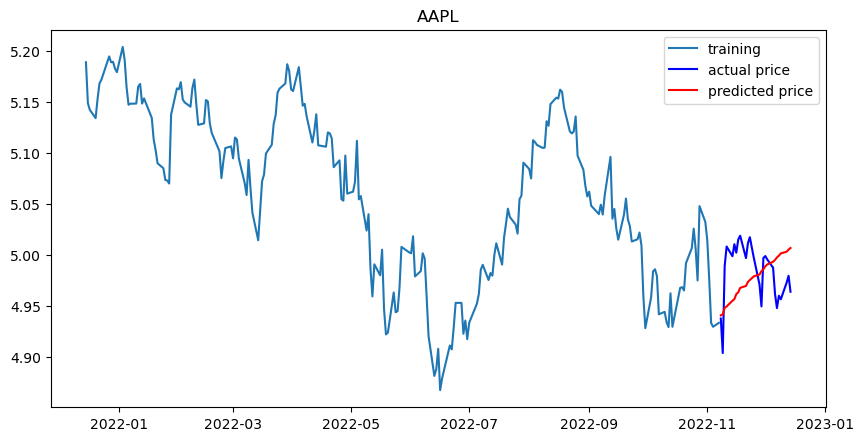

In [1525]:
aapl_fc = aapl_fitted_m.forecast(len(aapl_test_data), alpha=0.05) 
aapl_fc = np.array(aapl_fc)

aapl_fc_series = pd.Series(aapl_fc, index=aapl_test_data.index)  

print('\n [AAPL]')

plt.figure(figsize=(10,5), dpi=100)
plt.plot(aapl_train_data, label='training')
plt.plot(aapl_test_data, c='b', label='actual price')
plt.plot(aapl_fc_series, c='r',label='predicted price')
plt.legend()
plt.title('AAPL')
plt.show()


 [GOOG]


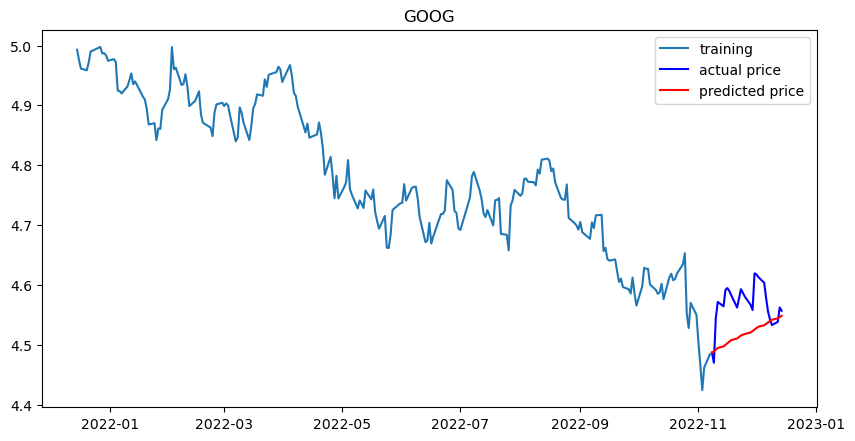

In [1526]:
goog_fc = goog_fitted_m.forecast(len(goog_test_data), alpha=0.05) 
goog_fc = np.array(goog_fc)

goog_fc_series = pd.Series(goog_fc, index=goog_test_data.index)  

print('\n [GOOG]')

plt.figure(figsize=(10,5), dpi=100)
plt.plot(goog_train_data, label='training')
plt.plot(goog_test_data, c='b', label='actual price')
plt.plot(goog_fc_series, c='r',label='predicted price')
plt.legend()
plt.title('GOOG')
plt.show()


 [AMZN]


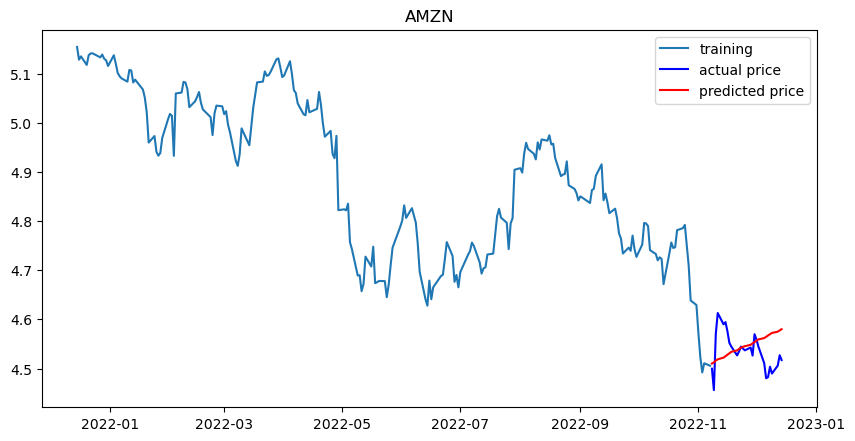

In [1527]:
amzn_fc = amzn_fitted_m.forecast(len(amzn_test_data), alpha=0.05) 
amzn_fc = np.array(amzn_fc)

amzn_fc_series = pd.Series(amzn_fc, index=amzn_test_data.index)  

print('\n [AMZN]')

plt.figure(figsize=(10,5), dpi=100)
plt.plot(amzn_train_data, label='training')
plt.plot(amzn_test_data, c='b', label='actual price')
plt.plot(amzn_fc_series, c='r',label='predicted price')
plt.legend()
plt.title('AMZN')
plt.show()

#
### [APPL]

In [1528]:
print('\n [APPL Result]')

aapl_mse = mean_squared_error(np.exp(aapl_test_data), np.exp(aapl_fc))
print('MSE: ', aapl_mse)

aapl_mae = mean_absolute_error(np.exp(aapl_test_data), np.exp(aapl_fc))
print('MAE: ', aapl_mae)

aapl_rmse = math.sqrt(mean_squared_error(np.exp(aapl_test_data), np.exp(aapl_fc)))
print('RMSE: ', aapl_rmse)

aapl_mape = np.mean(np.abs(np.exp(aapl_fc) - np.exp(aapl_test_data))/np.abs(np.exp(aapl_test_data)))
print('MAPE: {:.2f}%'.format(aapl_mape*100))


 [APPL Result]
MSE:  28.27696124822613
MAE:  4.7549290964954745
RMSE:  5.317608602391316
MAPE: 3.25%


#
### [GOOG]

In [1529]:
print('\n [GOOG Result]')

goog_mse = mean_squared_error(np.exp(goog_test_data), np.exp(goog_fc))
print('MSE: ', goog_mse)

goog_mae = mean_absolute_error(np.exp(goog_test_data), np.exp(goog_fc))
print('MAE: ', goog_mae)

goog_rmse = math.sqrt(mean_squared_error(np.exp(goog_test_data), np.exp(goog_fc)))
print('RMSE: ', goog_rmse)

goog_mape = np.mean(np.abs(np.exp(goog_fc) - np.exp(goog_test_data))/np.abs(np.exp(goog_test_data)))
print('MAPE: {:.2f}%'.format(goog_mape*100))


 [GOOG Result]
MSE:  32.71729604112936
MAE:  4.8624377446825084
RMSE:  5.7199034992847
MAPE: 4.96%


In [1530]:
print('\n [AMZN Result]')

amzn_mse = mean_squared_error(np.exp(amzn_test_data), np.exp(amzn_fc))
print('MSE: ', amzn_mse)

amzn_mae = mean_absolute_error(np.exp(amzn_test_data), np.exp(amzn_fc))
print('MAE: ', amzn_mae)

amzn_rmse = math.sqrt(mean_squared_error(np.exp(amzn_test_data), np.exp(amzn_fc)))
print('RMSE: ', amzn_rmse)

amzn_mape = np.mean(np.abs(np.exp(amzn_fc) - np.exp(amzn_test_data))/np.abs(np.exp(amzn_test_data)))
print('MAPE: {:.2f}%'.format(amzn_mape*100))


 [AMZN Result]
MSE:  23.078273650913857
MAE:  3.872681468524657
RMSE:  4.80398518429375
MAPE: 4.17%
